# Geodesics of $E(2) \ / \ \Gamma$ for different wallpaper groups $\Gamma$

Let $E(2)$ be the group of orientation-preserving isometries on the Euclidean plane $E^2$. In this notebook, we study periodic tilings of $E^2$ by nonoverlapping shapes with no gaps. For a tiling of $E^2$, we define its symmetry group $\Gamma\subseteq E(2)$ to be the subgroup of isometries that map the tiling to itself. 

The **point group** of $\Gamma$ is $\Gamma_0 = \{\rho_{\theta}\ | \ (a,\theta)\in \Gamma \text{ for some } a \in \mathbb{R}^2\}$

The **lattice** of $\Gamma$ is $\Gamma_L = \{a\in \mathbb{R}^2\ | \ (a,0)\in \Gamma\}$ 

If $\Gamma$ is the symmetry group of a tiling, one can show that:
1. $\Gamma_0\in \{C_1,C_2,C_3,C_4,C_6\}$ where $C_n = \{\rho_\theta \ | \ \theta = \frac{i \cdot 2 \pi}{n} \text{ for } i = 0,1,2,\ldots, n-1\}$ (we refer to these as the five wallpaper groups).
2. There exists linearly independent $a,b\in \mathbb{R}^2$ such that $\Gamma_L=\{ma+nb \ | \ m,n\in \mathbb{Z}\}$ (we refer to $a$ and $b$ as the lattice generators of $\Gamma$).

For a tiling with symmetry group $\Gamma$, we can build 3-dimensional parameterization of $E(2)\ / \ \Gamma$ that depends on the wallpaper group and the lattice generators. This notebook explores how to define distance on these parameterizations and how this can be used to study the homology of the parameterized space.

In [15]:
# importing needed libraries
import numpy as np
from numpy import pi
from math import dist
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams

In [38]:
# defining functions that will allow us to generate orientation-preserving isometries
def translation(a,b):
    def t_ab(x,y): 
        return x+a, y+b
    return t_ab

def rotation(theta):
    def r_theta(x,y):
        return x * cos(theta) - y * sin(theta), x * sin(theta) + y * cos(theta)
    return r_theta

def isom(a,b,theta):
    def iso(x,y):
        r = rotation(theta)
        t = translation(a,b)
        return t(r(x,y)[0], r(x,y)[1])
    return iso

In [39]:
# helpful functions for analyzing output from ripser, a persistent homology package
def persistent_H1_intervals(output):
    H1 = output['dgms'][1].tolist() # all intervals in H1
    d = []
    for pair in H1: 
        d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
    d.sort(reverse = True) # sorting from longest to shortest intervals
    d
    return d

def plot_dgms(output):
    dgms = output['dgms']
    fig = plt.figure(figsize = (12, 6))
    plot_diagrams(dgms)

# Let's start with a symmetry group whose point group is $C_1$

Note that each isometry is determined by a 2-dimentional translation and a rotation. Suppose $\Gamma$ is a symmetry group of a tiling with lattice generators $a,b\in \mathbb{R}^2$ and point group equal to $C_1$. Then we can parametrize $E(2) \ / \ \Gamma$ with a prism of height $2\pi$ whose base is the parallelogram spanned by $a$ and $b$ with the following identifications:
1. the front and back faces glue together 
2. the right and left faces glue together 
3. the top and bottom faces glue together

Note that this parameterizes the 3-torus. 

To find the distance between any two points $(x,y)$ in this prism, we have to consider 27 different "straight-line" geodesics that pass through various faces. To see this, fix the position of $x$ and consider possible locations of $y$ that could be obtained by duplicating the prism and gluing it to the original prism along one of the identifications. Fixing $\theta=0$, we can translate by $a,$ $-a$, $b,$ $-b$, some combination of these, or not translate at all. Considering $x$ in its original position, and $y$ in one of these translated positions, this corresponds to 9 of the 27 possible straight-lines. We get 9 more when we rotate by $2\pi$ and 9 more again when we rotate by $-2\pi$. We want to take the minimum distance across these 27 candidate distances.

In [53]:
# defining the distance function described above
def distance_C1(x, y, a, b):
    Y = []
    options = [-1,0,1]
    for option_a in options:
        for option_b in options:
            for option_c in options:
                Y.append([y[0] + a * option_a, y[1] + b * option_b, y[2] + 2*pi * option_c])
    
    distances = []
    for y_new in Y: 
        distances.append(dist(x,y_new))
        
    return min(distances)

In [54]:
# function to generate a sample of isometries inside of this prism
def generate_c1_isoms(n_isos, a, b):
    a = list(a * np.random.random(n_isos)) 
    b = list(b * np.random.random(n_isos)) 
    theta = list(2*pi * np.random.random(n_isos)) 
    
    isoms = []
    for i in range(n_isos):
        isoms.append((a[i],b[i],theta[i]))
        
    return isoms

In [55]:
# calculate the distance between each of these isometries and save this information in a matrix
# note that we must specifiy values of a and b

isoms = generate_c1_isoms(1000, 6, 6)

M = np.zeros((1000,1000))
for i in range(1000):
    for j in range(1000):
        M[i][j] = distance_C1(isoms[i], isoms[j],6,6)

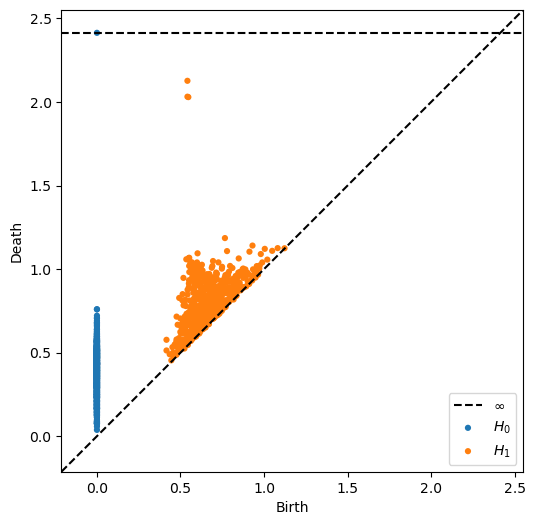

In [49]:
# feed this distance matrix in to ripser to calculate ther persistent homology of the space
# coefficients in Z2
output = ripser(M, maxdim = 1, coeff = 2, distance_matrix = True)
plot_dgms(output)

In [50]:
#there are three outliers!
persistent_H1_intervals(output)

[1.5851449370384216,
 1.4900017380714417,
 1.4821116924285889,
 0.5237690210342407,
 0.5164849758148193,
 0.5153790712356567,
 0.5013021230697632,
 0.4922749996185303,
 0.47108161449432373,
 0.4702901244163513,
 0.4670208692550659,
 0.4526676535606384,
 0.45262008905410767,
 0.45072877407073975,
 0.4493442177772522,
 0.4407714009284973,
 0.43237704038619995,
 0.4321402907371521,
 0.43170446157455444,
 0.42960917949676514,
 0.4295666217803955,
 0.4232328534126282,
 0.41961973905563354,
 0.4160415530204773,
 0.4130346179008484,
 0.4049970507621765,
 0.3991485834121704,
 0.397838294506073,
 0.3953571915626526,
 0.39400142431259155,
 0.38619840145111084,
 0.3838132619857788,
 0.3830265402793884,
 0.38200294971466064,
 0.3819214105606079,
 0.3781774044036865,
 0.377419650554657,
 0.37574756145477295,
 0.37450075149536133,
 0.3719552159309387,
 0.3688057065010071,
 0.3654636740684509,
 0.36357027292251587,
 0.3631519675254822,
 0.36178064346313477,
 0.3594791293144226,
 0.35770535469055176,


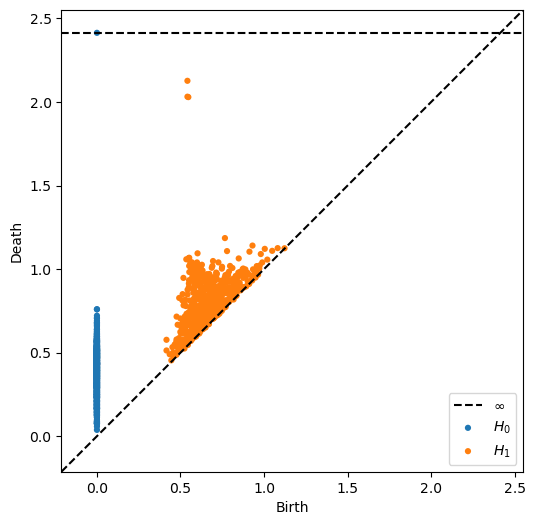

In [51]:
# do it again with coefficients in Z3
output = ripser(M, maxdim = 1, coeff = 3, distance_matrix = True)
plot_dgms(output)

In [52]:
# again we find three outliers
persistent_H1_intervals(output)

[1.5851449370384216,
 1.4900017380714417,
 1.4821116924285889,
 0.5237690210342407,
 0.5164849758148193,
 0.5153790712356567,
 0.5013021230697632,
 0.4922749996185303,
 0.47108161449432373,
 0.4702901244163513,
 0.4670208692550659,
 0.4526676535606384,
 0.45262008905410767,
 0.45072877407073975,
 0.4493442177772522,
 0.4407714009284973,
 0.43237704038619995,
 0.4321402907371521,
 0.43170446157455444,
 0.42960917949676514,
 0.4295666217803955,
 0.4232328534126282,
 0.41961973905563354,
 0.4160415530204773,
 0.4130346179008484,
 0.4049970507621765,
 0.3991485834121704,
 0.397838294506073,
 0.3953571915626526,
 0.39400142431259155,
 0.38619840145111084,
 0.3838132619857788,
 0.3830265402793884,
 0.38200294971466064,
 0.3819214105606079,
 0.3781774044036865,
 0.377419650554657,
 0.37574756145477295,
 0.37450075149536133,
 0.3719552159309387,
 0.3688057065010071,
 0.3654636740684509,
 0.36357027292251587,
 0.3631519675254822,
 0.36178064346313477,
 0.3594791293144226,
 0.35770535469055176,


As discussed above, our prism parameterizes the 3-torus, and our persistent homology output is consistent with the 3-torus!

# Now a point group that is $C_2$

Now let $\Gamma\subseteq E(2)$ a symmetry group whose point group is $C_2$. The prism we build to parameterize $E(2) \ / \ \Gamma$  will be similar to that above, but it will have height $\pi$ and the top face is identified with a rotation of the bottom face by $\pi$. This rotation identification slightly complicates where $y$ ends up after duplicating the prism and gluing along faces when a rotation has occured. Note that rotation by $\pi$ (or $-\pi$) around the center of the prism sends a point $(x_1,x_2)\in \mathbb{R}^2$ to $(a- x_1, b-x_2)$. We will again have 27 straight line distances to compare (9 at $\theta = 0$, 9 at $\theta = \pi$, and 9 at $\theta = -\pi).$ With the above identfications, when we calculate the persistent homology of the parameterized space, we expect to get 3 homology classes in the 1-dimensional homology vector space over $\mathbb{Z}_2$, and 1 homology class in the 1-dimensional homology vector space over $\mathbb{Z}_3.$

In [67]:
def distance_C2(x, y, a, b):
    
    # no rotations
    Y = []
    options = [-1,0,1]
    for option_a in options:
        for option_b in options:
            Y.append([y[0] + a * option_a, y[1] + b * option_b, y[2]])
    
    # rotate by pi
    options = [-1,0,1]
    for option_a in options:
        for option_b in options:
            Y.append([a - y[0] + a * option_a, b - y[1] + b * option_b, y[2] + pi])
        
    # rotate by -pi
    options = [-1,0,1]
    for option_a in options:
        for option_b in options:
            Y.append([a - y[0] + a * option_a, b - y[1] + b * option_b, y[2] - pi])
            
    distances = []
    for y_new in Y: 
        distances.append(dist(x,y_new))
        
    return min(distances)

In [68]:
# isometries that allow rotation up to pi
def generate_c2_isoms(n_isos, a, b):
    a = list(a * np.random.random(n_isos)) 
    b = list(b * np.random.random(n_isos)) 
    theta = list(pi * np.random.random(n_isos)) 
    
    isoms = []
    for i in range(n_isos):
        isoms.append((a[i],b[i],theta[i]))
        
    return isoms

In [69]:
# calculate the distance between each of these isometries and save this information in a matrix
isoms = generate_c2_isoms(1000, 3, 3)

M = np.zeros((1000,1000))
for i in range(1000):
    for j in range(1000):
        M[i][j] = distance_C2(isoms[i], isoms[j],3,3)

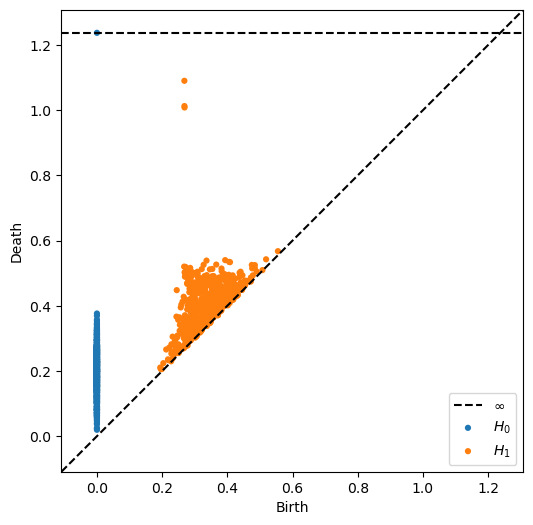

In [70]:
output = ripser(M, maxdim = 1, coeff = 2, distance_matrix = True)
plot_dgms(output)

In [71]:
# three outliers!
persistent_H1_intervals(output)

[0.8220115303993225,
 0.7443406283855438,
 0.7397236824035645,
 0.25264063477516174,
 0.24739935994148254,
 0.23938137292861938,
 0.2355571687221527,
 0.23461371660232544,
 0.23382747173309326,
 0.23338168859481812,
 0.23022639751434326,
 0.23014208674430847,
 0.22679412364959717,
 0.22550126910209656,
 0.22323161363601685,
 0.222244530916214,
 0.2218213975429535,
 0.21968433260917664,
 0.21939194202423096,
 0.2164066731929779,
 0.21331337094306946,
 0.20698481798171997,
 0.20640221238136292,
 0.20493239164352417,
 0.20319411158561707,
 0.20257702469825745,
 0.2013222873210907,
 0.20055794715881348,
 0.1986355483531952,
 0.1984315812587738,
 0.19596362113952637,
 0.1958114206790924,
 0.19503074884414673,
 0.19458237290382385,
 0.1923958659172058,
 0.19227266311645508,
 0.1911678910255432,
 0.19108733534812927,
 0.19004029035568237,
 0.18970414996147156,
 0.18229451775550842,
 0.18014007806777954,
 0.17910265922546387,
 0.17325344681739807,
 0.17308884859085083,
 0.17163711786270142,
 0

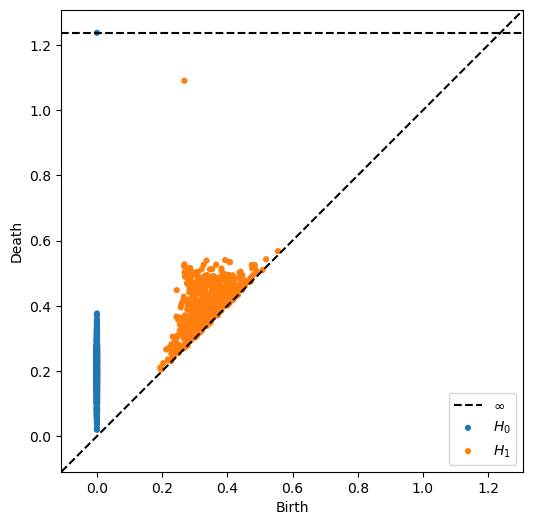

In [72]:
output = ripser(M, maxdim = 1, coeff = 3, distance_matrix = True)
plot_dgms(output)

In [74]:
# one outlier!
persistent_H1_intervals(output)

[0.8220115303993225,
 0.2584921717643738,
 0.2559521496295929,
 0.25169941782951355,
 0.24739935994148254,
 0.23938137292861938,
 0.2355571687221527,
 0.23461371660232544,
 0.23382747173309326,
 0.23338168859481812,
 0.23022639751434326,
 0.23014208674430847,
 0.22679412364959717,
 0.22550126910209656,
 0.22323161363601685,
 0.222244530916214,
 0.2218213975429535,
 0.21968433260917664,
 0.21939194202423096,
 0.2164066731929779,
 0.21331337094306946,
 0.20698481798171997,
 0.20640221238136292,
 0.20493239164352417,
 0.20319411158561707,
 0.20257702469825745,
 0.2013222873210907,
 0.20055794715881348,
 0.1986355483531952,
 0.1984315812587738,
 0.19596362113952637,
 0.1958114206790924,
 0.19503074884414673,
 0.19458237290382385,
 0.1923958659172058,
 0.19227266311645508,
 0.1911678910255432,
 0.19108733534812927,
 0.19004029035568237,
 0.18970414996147156,
 0.18229451775550842,
 0.18014007806777954,
 0.17910265922546387,
 0.17325344681739807,
 0.17308884859085083,
 0.17163711786270142,
 0

We get 3 homology classes over $\mathbb{Z}_2$, and 1 homology class over $\mathbb{Z}_3$ as wanted.

# Skipping to $C_4$

We jump ahead to $C_4$ because the parameterized prism looks similar to those in the $C_1$ and $C_2$ cases. Now the height is $\pi/2$ and the top face is identified with a rotation of the bottom face by $\pi/2$. Additionally, symmetry groups with point group of $C_4$ always have a square lattice $(a=b)$, so there is only one lattice generator to be specified. Rotation by $\pi/2$ around the center of the prism sends a point $(x_1,x_2)\in \mathbb{R}^2$ to $(a- x_2, x_1+a)$, and rotation by $-\pi.2$ sends $(x_1,x_2)\in \mathbb{R}^2$ to $(x_2+a,a-x-1)$. Again we have 27 straight line distances to compare (9 at $\theta = 0$, 9 at $\theta = \pi/2$, and 9 at $\theta = -\pi/2).$ We expect there to be 2 homology classes over $\mathbb{Z}_2$ and 1 over $\mathbb{Z}_1$.

In [389]:
def distance_C4(x, y, a):
    
    # no rotation
    Y = []
    options = [-1,0,1]
    for option_1 in options:
        for option_2 in options:
            Y.append([y[0] + a * option_1, y[1] + a * option_2, y[2]])
            
    # rotate by pi/2
    options = [-1,0,1]
    for option_1 in options:
        for option_2 in options:
            Y.append([a - y[1] + a * option_1, y[0] + a * option_2, y[2] + pi/2])
    
    # rotate by -pi/2
    options = [-1,0,1]
    for option_1 in options:
        for option_2 in options:
            Y.append([y[1] + a * option_1, -y[0] + a + a * option_2, y[2] - pi/2])
            
    distances = []
    for y_new in Y: 
        distances.append(dist(x,y_new))
        
    return distances

In [323]:
# isometries that allow rotation up to pi/2
def generate_c4_isoms(n_isos, x_translate, y_translate):
    a = list(x_translate * np.random.random(n_isos)) 
    b = list(y_translate * np.random.random(n_isos)) 
    theta = list(pi/2 * np.random.random(n_isos)) 
    
    isoms = []
    for i in range(n_isos):
        isoms.append((a[i],b[i],theta[i]))
        
    return isoms

In [324]:
isoms = generate_c4_isoms(1000, 1, 1)

M = np.zeros((1000,1000))
for i in range(1000):
    for j in range(1000):
        M[i][j] = distance_C4(isoms[i], isoms[j], 1)

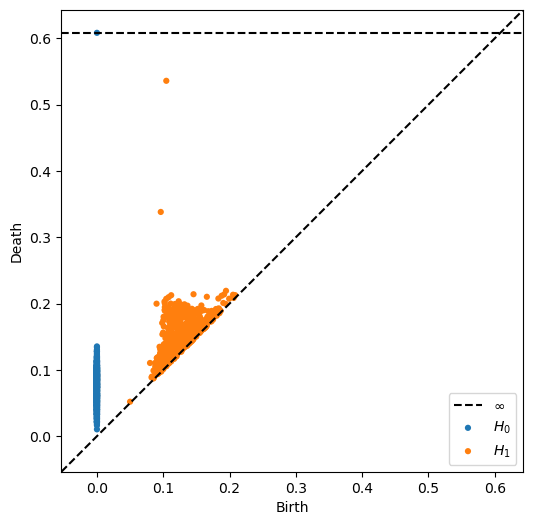

In [297]:
output = ripser(M, maxdim = 1, coeff = 2, distance_matrix = True)
plot_dgms(output)

In [298]:
# 2 outliers
persistent_H1_intervals(output)

[0.43145930022001266,
 0.24197161942720413,
 0.10996775329113007,
 0.10266460478305817,
 0.10151172429323196,
 0.10115039348602295,
 0.10061172395944595,
 0.09803098440170288,
 0.09229226410388947,
 0.08927899599075317,
 0.08881209790706635,
 0.0883900597691536,
 0.08800047636032104,
 0.08711761236190796,
 0.08654879778623581,
 0.086258165538311,
 0.08561311662197113,
 0.08173433691263199,
 0.08051276206970215,
 0.08026067912578583,
 0.07992339879274368,
 0.07992292940616608,
 0.07977373152971268,
 0.0795656368136406,
 0.07799243181943893,
 0.07762202620506287,
 0.07707703113555908,
 0.07633218169212341,
 0.07627137005329132,
 0.07591193169355392,
 0.07513418793678284,
 0.074759840965271,
 0.07445330917835236,
 0.07393059134483337,
 0.07316078245639801,
 0.0723579153418541,
 0.07211698591709137,
 0.0720229372382164,
 0.07119562476873398,
 0.07073801755905151,
 0.07024005055427551,
 0.06943445652723312,
 0.06843152642250061,
 0.06744575500488281,
 0.06741269677877426,
 0.067336037755012

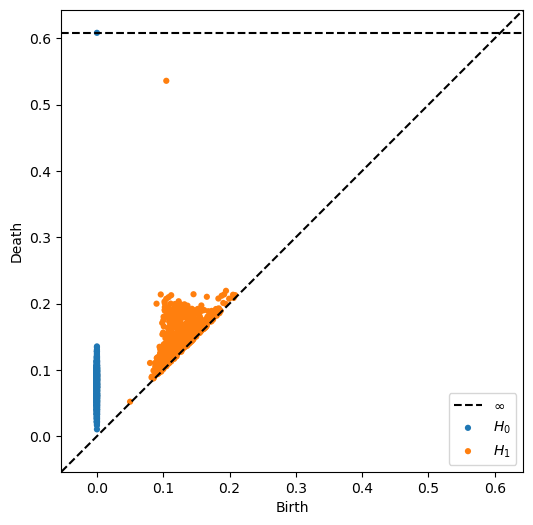

In [299]:
output = ripser(M, maxdim = 1, coeff = 3, distance_matrix = True)
plot_dgms(output)

In [300]:
# 1 outlier
persistent_H1_intervals(output)

[0.43145930022001266,
 0.11749079078435898,
 0.10996775329113007,
 0.10266460478305817,
 0.10151172429323196,
 0.10115039348602295,
 0.10061172395944595,
 0.09803098440170288,
 0.09229226410388947,
 0.08927899599075317,
 0.08881209790706635,
 0.0883900597691536,
 0.08800047636032104,
 0.08711761236190796,
 0.08654879778623581,
 0.086258165538311,
 0.08561311662197113,
 0.08173433691263199,
 0.08051276206970215,
 0.08026067912578583,
 0.07992339879274368,
 0.07992292940616608,
 0.07977373152971268,
 0.0795656368136406,
 0.07799243181943893,
 0.07762202620506287,
 0.07707703113555908,
 0.07633218169212341,
 0.07627137005329132,
 0.07591193169355392,
 0.07513418793678284,
 0.074759840965271,
 0.07445330917835236,
 0.07393059134483337,
 0.07316078245639801,
 0.0723579153418541,
 0.07211698591709137,
 0.0720229372382164,
 0.07119562476873398,
 0.07073801755905151,
 0.07024005055427551,
 0.06943445652723312,
 0.06843152642250061,
 0.06744575500488281,
 0.06741269677877426,
 0.067336037755012

# Now we go back to $C_3$ (the troublemaker)

The parameterization gets slightly more complex for $C_3$. The base of our prism is no longer defined by a paralellogram with four sides, but rather a regular hexagon. Each rectangular side of the hexagonal prism is identified with its opposing parallel side. The height of the prism is $2\pi/3$ and the top face is identified with a rotation of the bottom face by $2\pi/3$. Rotation by $2\pi/3$ around the center of the prism whose base is a regular hexagon sends a point $(x_1,x_2)\in \mathbb{R}^2$ to $(-1/2 \cdot x_1 - \sqrt{3}/2\cdot x_2 , -1/2 \cdot x_2 + \sqrt{3}/2\cdot x_1)$, and rotation by $-2\pi/3$ sends $(x_1,x_2)\in \mathbb{R}^2$ to $(-1/2 \cdot x_1 + \sqrt{3}/2\cdot x_2 , -1/2 \cdot x_2 - \sqrt{3}/2\cdot x_1)$. Fixing $\theta = 0$, we can duplicate the prism and glue it along an identification of any of its six rectangular faces, or not translate at all. Thus we get 7 possible new locations for $y$. We get 7 more when we rotate by $2\pi/3$, and 7 more again when we rotate by $-2\pi/3$. Thus we compare 21 straight line distances. We now expect there to be 1 homology class over $\mathbb{Z}_2$ and 2 over $\mathbb{Z}_1$.

In [179]:
def distance_C3(x, y, a):
    
    # no translation in rotation axis
    Y = [y] # no translation in any axis
    for i in [1,-1]:
        Y.append((y[0], y[1]+ i * (3**0.5) * a, y[2])) # front and back
        Y.append((y[0] + i * (3/2) * a, y[1] - (3**0.5)/2 * a, y[2])) # LB and RF
        Y.append((y[0] + i * (3/2) * a, y[1] + (3**0.5)/2 * a, y[2])) # LF and RB
        
    # rotate by 2pi/3
    Y.append((-1/2 * y[0] - (3**0.5)/2 * y[1], -1/2 * y[1] + (3**0.5)/2 * y[0], y[2] + 2*pi/3)) # only rotation by 2pi/3
    for i in [1,-1]:
        y1 = -1/2 * y[0] - (3**0.5)/2 * y[1]
        y2 = -1/2 * y[1] + (3**0.5)/2 * y[0] 
        Y.append((y1, y2 + i * (3**0.5) * a, y[2] + 2*pi/3)) # front and back
        Y.append((y1 + i * (3/2) * a, y2 - (3**0.5)/2 * a, y[2] + 2*pi/3)) # LB and RF
        Y.append((y1 + i * (3/2) * a, y2 + (3**0.5)/2 * a, y[2] + 2*pi/3)) # LF and RB    
    
    # rotate by -2pi/3
    Y.append((-1/2 * y[0] + (3**0.5)/2 * y[1], -1/2 * y[1] - (3**0.5)/2 * y[0], y[2] - 2*pi/3)) # only rotation by -2pi/3
    for i in [1,-1]:
        y1 = -1/2 * y[0]+ (3**0.5)/2 * y[1]
        y2 = -1/2 * y[1] - (3**0.5)/2 * y[0]
        Y.append((y1, y2 + i * (3**0.5) * a, y[2] - 2*pi/3)) # front and back
        Y.append((y1 + i * (3/2) * a, y2 - (3**0.5)/2 * a, y[2] - 2*pi/3)) # LB and RF
        Y.append((y1 + i * (3/2) * a, y2 + (3**0.5)/2 * a, y[2] - 2*pi/3)) # LF and RB   
    
    distances = []
    for y_new in Y: 
        distances.append(dist(x,y_new))
        
    return min(distances)

In [180]:
# allow only for rotations up to 2pi/3
# we first sample from a rectangular patch of the plane and then cut off the corners to create a hexagonal shape

def generate_c3_isoms(n_isos, a):
    X = list(2 * a * np.random.random(2 * n_isos) - a)  
    Y = list((3**0.5) * a * np.random.random(2 * n_isos) - (3**0.5)/2 * a)
    theta = list(2*pi/3 * np.random.random(2 * n_isos))
    
    i = 0
    hexagon = []
    while len(hexagon) < n_isos:
        if (Y[i] > -(3**0.5) * a + (3**0.5) * X[i]) and (Y[i] > -(3**0.5) * a - (3**0.5) * X[i]) and (Y[i] < (3**0.5) * a + (3**0.5) * X[i]) and (Y[i] < (3**0.5) * a - (3**0.5) * X[i]):  
            hexagon.append((X[i], Y[i], theta[i]))
        i = i + 1
    
    return hexagon

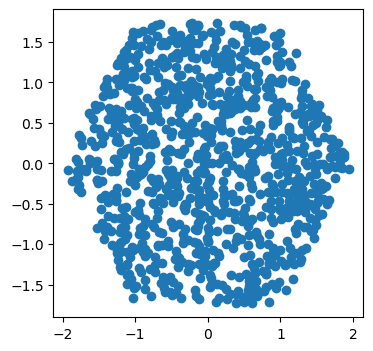

In [181]:
hexagon = generate_c3_isoms(1000, 2)

X = []
Y = []
for i in range(len(hexagon)):
    X.append(hexagon[i][0])
    Y.append(hexagon[i][1])

fig = plt.figure(figsize = (4, 4))
ax = plt.axes()
ax.scatter(X, Y)
plt.show()

In [182]:
isoms = generate_c3_isoms(1000, 1)

M = np.zeros((1000,1000))
for i in range(1000):
    for j in range(1000):
        M[i][j] = distance_C3(isoms[i], isoms[j], 1)

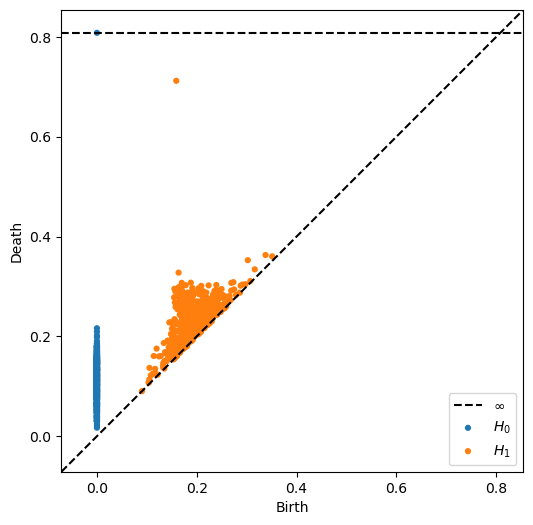

In [183]:
output = ripser(M, maxdim = 1, coeff = 2, distance_matrix = True)
plot_dgms(output)

In [184]:
# one outlier
persistent_H1_intervals(output)

[0.5529760271310806,
 0.16413190960884094,
 0.14017461240291595,
 0.1374095231294632,
 0.13463318347930908,
 0.13309171795845032,
 0.13283807039260864,
 0.13257645070552826,
 0.13127030432224274,
 0.13120269775390625,
 0.12628476321697235,
 0.12573763728141785,
 0.12481483817100525,
 0.12473085522651672,
 0.12364983558654785,
 0.12085555493831635,
 0.11961963772773743,
 0.11944162845611572,
 0.11888490617275238,
 0.11865508556365967,
 0.11784037947654724,
 0.11584599316120148,
 0.11554226279258728,
 0.11456401646137238,
 0.11332602798938751,
 0.11328116059303284,
 0.11263646185398102,
 0.1120738834142685,
 0.11202763020992279,
 0.11179959774017334,
 0.11048147082328796,
 0.10951492190361023,
 0.10894609987735748,
 0.10846972465515137,
 0.10835319757461548,
 0.10607899725437164,
 0.10593599081039429,
 0.10494637489318848,
 0.10463176667690277,
 0.10432499647140503,
 0.10414068400859833,
 0.10335323214530945,
 0.10311019420623779,
 0.10254043340682983,
 0.10152226686477661,
 0.1012107580

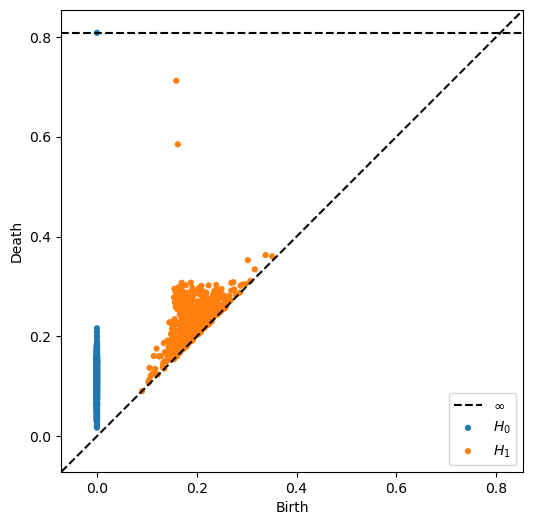

In [185]:
output = ripser(M, maxdim = 1, coeff = 3, distance_matrix = True)
plot_dgms(output)

In [186]:
# two outliers!!
persistent_H1_intervals(output)

[0.5529760271310806,
 0.4225550591945648,
 0.14017461240291595,
 0.1374095231294632,
 0.13463318347930908,
 0.13309171795845032,
 0.13257645070552826,
 0.13133594393730164,
 0.13127030432224274,
 0.13120269775390625,
 0.12628476321697235,
 0.12573763728141785,
 0.12481483817100525,
 0.12473085522651672,
 0.12364983558654785,
 0.12085555493831635,
 0.11961963772773743,
 0.11944162845611572,
 0.11888490617275238,
 0.11865508556365967,
 0.11784037947654724,
 0.11584599316120148,
 0.11554226279258728,
 0.11456401646137238,
 0.11332602798938751,
 0.11328116059303284,
 0.11263646185398102,
 0.1120738834142685,
 0.11202763020992279,
 0.11179959774017334,
 0.11048147082328796,
 0.10951492190361023,
 0.10894609987735748,
 0.10846972465515137,
 0.10835319757461548,
 0.10607899725437164,
 0.10593599081039429,
 0.10494637489318848,
 0.10463176667690277,
 0.10432499647140503,
 0.10414068400859833,
 0.10335323214530945,
 0.10311019420623779,
 0.10254043340682983,
 0.10152226686477661,
 0.10121075809

# And finally $C_6$

We again have a hexagonal prism as our parameterization for a symmetry group with $C_6$ point group. However, now the height of the prism is $pi/3$ and the top face is identified with a rotation of the bottom face by $pi/3$. Rotation by $pi/3$ around the center of the prism whose base is a regular hexagon sends a point $(x_1,x_2)\in \mathbb{R}^2$ to $(1/2 \cdot x_1 - \sqrt{3}/2\cdot x_2 , 1/2 \cdot x_2 + \sqrt{3}/2\cdot x_1)$, and rotation by $-2\pi/3$ sends $(x_1,x_2)\in \mathbb{R}^2$ to $(1/2 \cdot x_1 + \sqrt{3}/2\cdot x_2 , 1/2 \cdot x_2 - \sqrt{3}/2\cdot x_1)$. We still have 21 distances to compare. We expect to get 1 homology class over $\mathbb{Z}_2$ and 1 over $\mathbb{Z}_1$.

In [187]:
def distance_C6(x, y, a):
    
    # no translation in rotation axis
    Y = [y] # no translation in any axis
    for i in [1,-1]:
        Y.append((y[0], y[1] + i * (3**0.5) * a, y[2])) # front and back
        Y.append((y[0] + i * (3/2) * a, y[1] - (3**0.5)/2 * a, y[2])) # LB and RF
        Y.append((y[0] + i * (3/2) * a, y[1] + (3**0.5)/2 * a, y[2])) # LF and RB
        
    # rotation by pi/3
    Y.append((1/2 * y[0] - (3**0.5)/2 * y[1], 1/2 * y[1] + (3**0.5)/2 * y[0], y[2] + pi/3)) # only rotation by 2pi/3
    for i in [1,-1]:
        y1 = 1/2 * y[0] - (3**0.5)/2 * y[1]
        y2 = 1/2 * y[1] + (3**0.5)/2 * y[0] 
        Y.append((y1, y2 + i * (3**0.5) * a, y[2] + 2*pi/3)) # front and back
        Y.append((y1 + i * (3/2) * a, y2 - (3**0.5)/2 * a, y[2] + pi/3)) # LB and RF
        Y.append((y1 + i * (3/2) * a, y2 + (3**0.5)/2 * a, y[2] + pi/3)) # LF and RB    
    
    # rotation by -pi/3
    Y.append((1/2 * y[0] + (3**0.5)/2 * y[1], 1/2 * y[1] - (3**0.5)/2 * y[0], y[2] - pi/3)) # only rotation by -2pi/3
    for i in [1,-1]:
        y1 = 1/2 * y[0]+ (3**0.5)/2 * y[1]
        y2 = 1/2 * y[1] - (3**0.5)/2 * y[0]
        Y.append((y1, y2 + i * (3**0.5) * a, y[2] - 2*pi/3)) # front and back
        Y.append((y1 + i * (3/2) * a, y2 - (3**0.5)/2 * a, y[2] - pi/3)) # LB and RF
        Y.append((y1 + i * (3/2) * a, y2 + (3**0.5)/2 * a, y[2] - pi/3)) # LF and RB   
    
    distances = []
    for y_new in Y: 
        distances.append(dist(x,y_new))
        
    return min(distances)

In [188]:
# only allow rotation up to pi/3
def generate_c6_isoms(n_isos, a):
    X = list(2 * a * np.random.random(2 * n_isos) - a)  
    Y = list((3**0.5) * a * np.random.random(2 * n_isos) - (3**0.5)/2 * a)
    theta = list(pi/3 * np.random.random(2 * n_isos))
    
    i = 0
    hexagon = []
    while len(hexagon) < n_isos:
        if (Y[i] > -(3**0.5) * a + (3**0.5) * X[i]) and (Y[i] > -(3**0.5) * a - (3**0.5) * X[i]) and (Y[i] < (3**0.5) * a + (3**0.5) * X[i]) and (Y[i] < (3**0.5) * a - (3**0.5) * X[i]):  
            hexagon.append((X[i], Y[i], theta[i]))
        i = i + 1
    
    return hexagon

In [189]:
isoms = generate_c6_isoms(1000, .5)

M = np.zeros((1000,1000))
for i in range(1000):
    for j in range(1000):
        M[i][j] = distance_C6(isoms[i], isoms[j], .5)

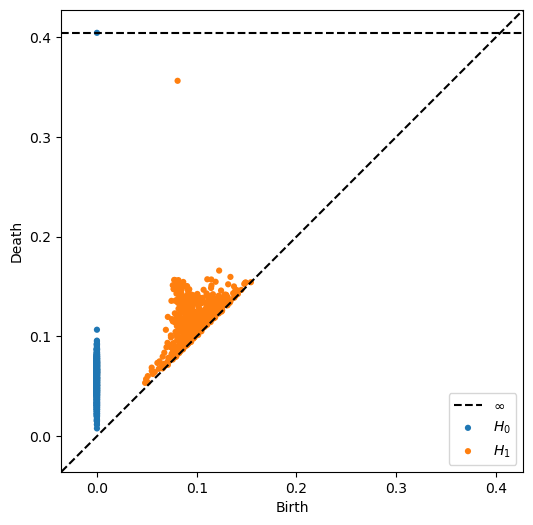

In [190]:
output = ripser(M, maxdim = 1, coeff = 2, distance_matrix = True)
plot_dgms(output)

In [191]:
#one outlier
persistent_H1_intervals(output)

[0.2753588482737541,
 0.0791933685541153,
 0.07849735021591187,
 0.07530393451452255,
 0.07481805980205536,
 0.07389792054891586,
 0.07202082872390747,
 0.07108427584171295,
 0.07061518728733063,
 0.07030075043439865,
 0.068075031042099,
 0.06751319766044617,
 0.06738952547311783,
 0.06651020050048828,
 0.06502643972635269,
 0.06357870995998383,
 0.06313502788543701,
 0.06284377723932266,
 0.06270246207714081,
 0.061923153698444366,
 0.06099088490009308,
 0.06084996461868286,
 0.06010684370994568,
 0.05831880122423172,
 0.05733475089073181,
 0.0572681799530983,
 0.05725492537021637,
 0.056640878319740295,
 0.055690914392471313,
 0.054720908403396606,
 0.054569393396377563,
 0.05432672053575516,
 0.05347665399312973,
 0.05274102836847305,
 0.052660636603832245,
 0.05208929628133774,
 0.052028290927410126,
 0.051598504185676575,
 0.05153893679380417,
 0.05098838359117508,
 0.05094003677368164,
 0.05086614936590195,
 0.05038372427225113,
 0.05005839467048645,
 0.04981033504009247,
 0.0496

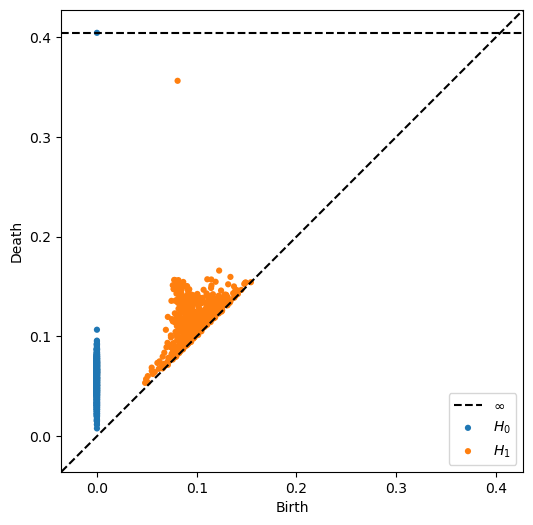

In [192]:
output = ripser(M, maxdim = 1, coeff = 3, distance_matrix = True)
plot_dgms(output)

In [193]:
#one outlier
persistent_H1_intervals(output)

[0.2753588482737541,
 0.0791933685541153,
 0.07849735021591187,
 0.07530393451452255,
 0.07481805980205536,
 0.07389792054891586,
 0.07202082872390747,
 0.07108427584171295,
 0.07061518728733063,
 0.07030075043439865,
 0.068075031042099,
 0.06751319766044617,
 0.06738952547311783,
 0.06651020050048828,
 0.06502643972635269,
 0.06357870995998383,
 0.06313502788543701,
 0.06284377723932266,
 0.06270246207714081,
 0.061923153698444366,
 0.06099088490009308,
 0.06084996461868286,
 0.06010684370994568,
 0.05831880122423172,
 0.05733475089073181,
 0.0572681799530983,
 0.05725492537021637,
 0.056640878319740295,
 0.055690914392471313,
 0.054720908403396606,
 0.054569393396377563,
 0.05432672053575516,
 0.05347665399312973,
 0.05274102836847305,
 0.052660636603832245,
 0.05208929628133774,
 0.052028290927410126,
 0.051598504185676575,
 0.05153893679380417,
 0.05098838359117508,
 0.05094003677368164,
 0.05086614936590195,
 0.05038372427225113,
 0.05005839467048645,
 0.04981033504009247,
 0.0496